##State-Farm-Distracted-Driver-Detection
##Transfer learning 

##import libraries

In [1]:
import pandas as pd 
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import cv2
import os  
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dense,Flatten, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD, Adam

##load data

In [2]:
from google.colab import files

files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                       title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ruchi798/data-science-job-salaries                        Data Science Job Salaries                            7KB  2022-06-15 08:59:12           6957        232  1.0              
surajjha101/bigbasket-entire-product-list-28k-datapoints  BigBasket Entire Product List (~28K datapoints)      6MB  2022-06-22 12:51:18           2322         99  1.0              
victorsoeiro/netflix-tv-shows-and-movies                  Netflix TV Shows and Movies                          2MB  2022-05-15 00:01:23          17121        495  1.0            

In [3]:
! kaggle competitions download -c state-farm-distracted-driver-detection

state-farm-distracted-driver-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
! unzip /content/state-farm-distracted-driver-detection.zip

Archive:  /content/state-farm-distracted-driver-detection.zip
replace driver_imgs_list.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

##preprocessing data

In [5]:
def preparData(path):
  imagsList = []
  labels = []
  for dic in sorted(glob.glob(os.path.join(path,'*')), key = lambda k: k.split('/')[-1]):
    for imgs in glob.glob(os.path.join(dic, '*.jpg')):
      img = cv2.imread(imgs)
      img_r = cv2.resize(img,(128,128))
      imagsList.append(img_r)
      labels.append(int(dic.split("/")[-1].replace('c','')))
  
  X_train, X_test, y_train, y_test = train_test_split(imagsList, labels, test_size=0.2,shuffle= True, random_state = 0)
  y_train = to_categorical(y_train)
  y_test  = to_categorical(y_test)

  return np.array(X_train), np.array(X_test), y_train, y_test


In [6]:
path_train = "/content/imgs/train/"
path_test  = "/content/imgs/test/"

X_train, X_test, y_train, y_test = preparData(path_train)

#shapes of traning and testing
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")

X_train shape: (17939, 128, 128, 3)
y_train shape: (17939, 10)
X_test shape:  (4485, 128, 128, 3)
y_test shape:  (4485, 10)


In [7]:
#normalize data
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

##Visualize examples of data

##classes: 
              c0: Safe driving 
              c1: Texting - right 
              c2: Talking on the phone - right 
              c3: Texting - left
              c4: Talking on the phone - left
              c5: Operating the radio
              c6: Drinking
              c7: Reaching behind 
              c8: Hair and makeup 
              c9: Talking to passenger


(128, 128, 3)


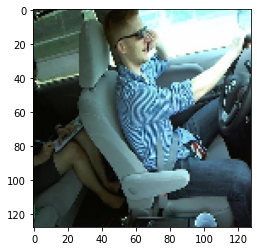

Class: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [8]:
print(X_train[800].shape)
img = X_train[800]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
print(f"Class: {y_train[800]}")

##4- Transfer learning 

##VGG16 model

In [8]:
from keras import applications
from tensorflow.keras.applications import VGG16

#pre-trained model that used weighted to use it in my new model
tune_model = applications.vgg16.VGG16(weights='imagenet',
                                      include_top=False,
                                      input_shape=(128, 128, 3))
tune_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [9]:
#use my new model 
model = Sequential()

#add layer that in tune_model to my model
for layer in tune_model.layers:
  model.add(layer)

#to add a new layers for model 
for layer in model.layers:
  layer.trainable = False

In [10]:
#build a my new model

model.add(Flatten())
model.add(Dense(256,activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(10,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 32, 32, 256)       2

In [11]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
history=model.fit(X_train, y_train, 
                  epochs=10, 
                  validation_data =(X_test, y_test))

Epoch 1/10
561/561 [==============================] - 51s 70ms/step - loss: 0.3910 - accuracy: 0.8873 - val_loss: 0.1052 - val_accuracy: 0.9697
Epoch 2/10
561/561 [==============================] - 40s 72ms/step - loss: 0.0692 - accuracy: 0.9789 - val_loss: 0.0648 - val_accuracy: 0.9808
Epoch 3/10
561/561 [==============================] - 39s 70ms/step - loss: 0.0407 - accuracy: 0.9878 - val_loss: 0.0612 - val_accuracy: 0.9806
Epoch 4/10
561/561 [==============================] - 39s 70ms/step - loss: 0.0461 - accuracy: 0.9853 - val_loss: 0.0967 - val_accuracy: 0.9746
Epoch 5/10
561/561 [==============================] - 39s 70ms/step - loss: 0.0299 - accuracy: 0.9898 - val_loss: 0.1126 - val_accuracy: 0.9661
Epoch 6/10
561/561 [==============================] - 39s 70ms/step - loss: 0.0343 - accuracy: 0.9880 - val_loss: 0.0594 - val_accuracy: 0.9853
Epoch 7/10
561/561 [==============================] - 39s 70ms/step - loss: 0.0303 - accuracy: 0.9901 - val_loss: 0.0474 - val_accuracy:

In [13]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


##Analysis result 

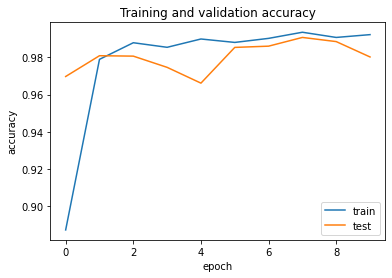

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.show()

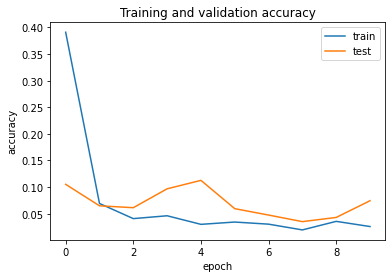

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'])
plt.show()